In [1]:
import os
from time import sleep
from tqdm import tqdm

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras import regularizers

from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns


C:\Users\nicho\AppData\Local\Temp\ipykernel_24872\4018668811.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# base_path = '/Users/nicholastey/Desktop/thesis/gnss_spoof_detector/spoof_detector/data/'
base_path = 'C:/Users/nicho/Desktop/gnss_spoof_detector/spoof_detector/data'

In [3]:
cs_path, ds1_path, ds3_path, ds2_path, ds4_path, ds7_path, ds8_path = [os.path.join(base_path, ds_path) for ds_path in os.listdir(base_path)]

In [4]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 
           'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 
           'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
    tmp_path = os.path.join(base_path, ds_fname)
    key = ds_fname.split('.')[0]
    
    tmp_df = pd.read_csv(tmp_path, header=None)
    prn_li = []
    
    for i in range(8):
        prn_li.append(int(tmp_df.iloc[1, 11*i+1]))

    globals()[f'{key}_dict'] = {
        int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:11].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:22].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:33].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:44].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:55].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:66].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:77].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:88].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        'prn' : prn_li
    }


channel - channel assigned to track satelite signal
prn - unique satelite identifier
acq_doopler_hz - doppler freq shift detected during signal acquisition, how fast satelite is moving relative to receiver
acq_doppler_step - step size 
fs - sampling freq

prompt_i - in phase measurement
prompt_q - quadrature measurement
cn0_db_hz - carrier to noise 
carrier_doppler_hz - doppler shift of carrier freq

pseudorange_m - distance to sattlite based on signal timing
rx_time - timestamp when signal was recived

feature engineering
    use iq to compute signal mag and phase?
        mag = sqrt(i^2+q^2)
        phase = atan2(q,i)
    rolling window of features to measure variance
    delta features


In [5]:
big_df = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 2),
    (ds3_dict, 3),
    (ds4_dict, 4),
    (ds7_dict, 5),
    (ds8_dict, 6)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df = dataset[prn].copy()
        df['spoofed'] = label
        df['prn'] = prn
        big_df.append(df)

big_df = pd.concat(big_df, ignore_index=True)
big_df

,channel,prn,acq_doopler_hz,acq_doppler_step,fs,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time,spoofed
0,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
1,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
2,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
3,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
4,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
189267,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189268,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189269,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189270,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6


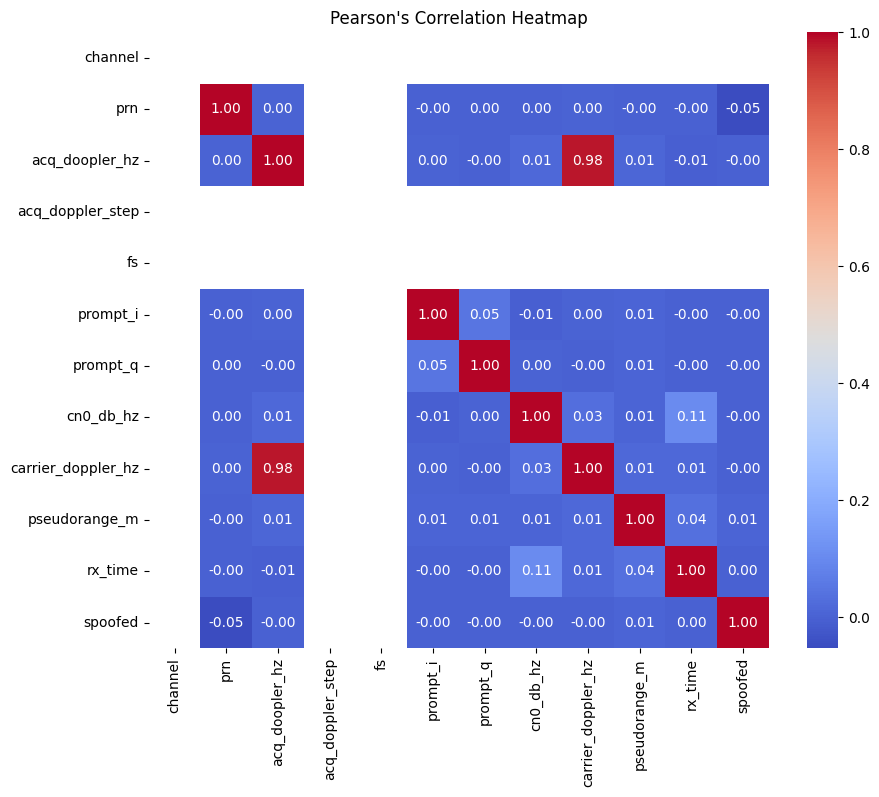

In [6]:
# Compute the correlation matrix
correlation_matrix = big_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [7]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 
           'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 
           'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
    tmp_path = os.path.join(base_path, ds_fname)
    key = ds_fname.split('.')[0]
    
    tmp_df = pd.read_csv(tmp_path, header=None)
    prn_li = []
    
    for i in range(8):
        prn_li.append(int(tmp_df.iloc[1, 11*i+1]))

    globals()[f'{key}_dict'] = {
        int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:11].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:22].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:33].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:44].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:55].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:66].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:77].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:88].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        'prn' : prn_li
    }


In [8]:
big_df_no_diff = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 2),
    (ds3_dict, 3),
    (ds4_dict, 4),
    (ds7_dict, 5),
    (ds8_dict, 6)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df_no_diff = dataset[prn].copy()
        df_no_diff['spoofed'] = label
        df_no_diff['prn'] = prn
        big_df_no_diff.append(df_no_diff)

big_df_no_diff = pd.concat(big_df_no_diff, ignore_index=True)
big_df_no_diff

,channel,prn,acq_doopler_hz,acq_doppler_step,fs,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time,spoofed
0,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
1,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
2,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
3,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
4,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
189267,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189268,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189269,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189270,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6


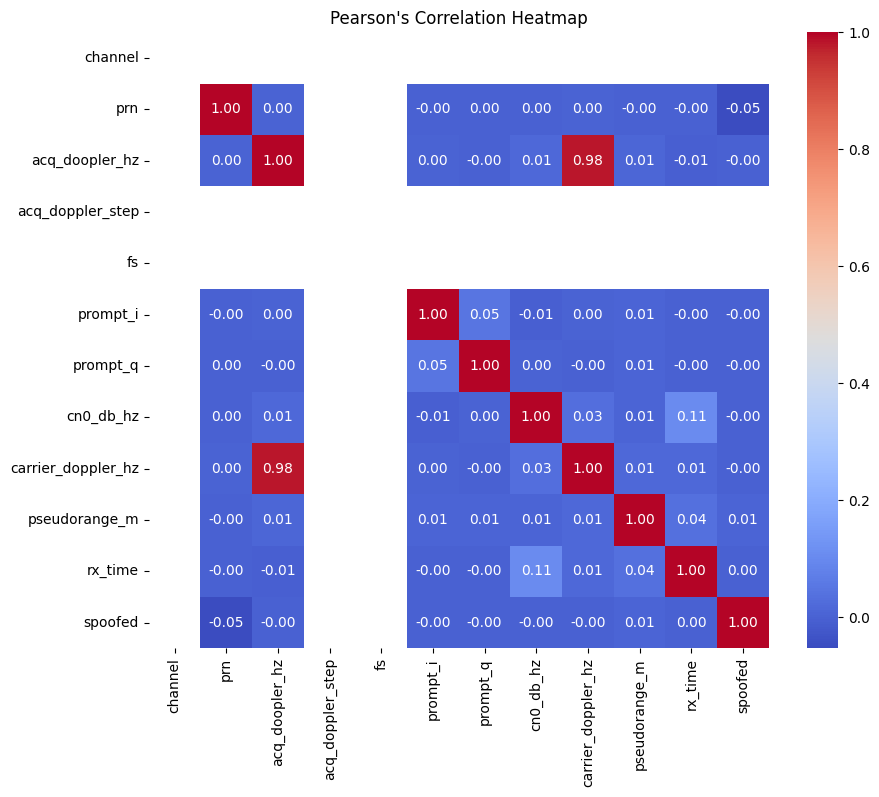

In [9]:
# Compute the correlation matrix
correlation_matrix_no_diff = big_df_no_diff.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_no_diff, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [29]:
#scale data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(big_df.drop(columns=['channel', 'prn', 'spoofed', 'fs', 'acq_doppler_step', 'rx_time', 'pseudorange_m', 'acq_doopler_hz']))

scaled_df = pd.DataFrame(scaled_df, columns=big_df.drop(columns=['channel', 'prn', 'spoofed', 'fs', 'acq_doppler_step', 'rx_time', 'pseudorange_m', 'acq_doopler_hz']).columns)
scaled_df['spoofed'] = big_df['spoofed'].values


In [30]:
#scale data
scaler = StandardScaler()
scaled_df_no_diff = scaler.fit_transform(big_df_no_diff.drop(columns=['channel', 'prn', 'spoofed', 'fs', 'acq_doppler_step', 'rx_time', 'pseudorange_m', 'acq_doopler_hz']))

scaled_df_no_diff = pd.DataFrame(scaled_df_no_diff, columns=big_df.drop(columns=['channel', 'prn', 'spoofed', 'fs', 'acq_doppler_step', 'rx_time', 'pseudorange_m', 'acq_doopler_hz']).columns)
scaled_df_no_diff['spoofed'] = big_df_no_diff['spoofed'].values


In [31]:
# SVM with diff
X = scaled_df.drop(columns=['spoofed'])
y = scaled_df['spoofed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

X_no_diff = scaled_df_no_diff.drop(columns=['spoofed'])
y_no_diff = scaled_df_no_diff['spoofed']

X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff = train_test_split(X_no_diff, y_no_diff, test_size=0.2, shuffle=True)
X_train_no_diff, X_val_no_diff, y_train_no_diff, y_val_no_diff = train_test_split(X_train_no_diff, y_train_no_diff, test_size=0.2, shuffle=True)    

In [32]:
X_train

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz
25372,-0.000022,0.000140,0.001484,0.002573
36231,-0.013210,-0.312853,-3.756881,-0.180208
116014,-0.000022,0.000140,0.001484,0.002573
132078,-0.000022,0.000140,0.001484,0.002573
149453,0.011084,1.190273,0.580555,-0.095353
...,...,...,...,...
45284,-0.000022,0.000140,0.001484,0.002573
30034,-0.000022,0.000140,0.001484,0.002573
52867,-0.000022,0.000140,0.001484,0.002573
4846,-0.000022,0.000140,0.001484,0.002573


In [33]:
X_train_no_diff

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz
67952,-0.000022,0.000140,0.001484,0.002573
76668,-0.000022,0.000140,0.001484,0.002573
28055,-0.000022,0.000140,0.001484,0.002573
30051,-0.021699,1.113233,2.073521,0.057229
115171,-0.000022,0.000140,0.001484,0.002573
...,...,...,...,...
150849,-0.000022,0.000140,0.001484,0.002573
33765,-0.000022,0.000140,0.001484,0.002573
162503,-0.000022,0.000140,0.001484,0.002573
92957,-0.000022,0.000140,0.001484,0.002573


In [34]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

spoofed
6    0.147070
5    0.146987
1    0.145171
4    0.143966
2    0.142059
0    0.137452
3    0.137295
Name: proportion, dtype: float64
spoofed
6    0.146110
1    0.145846
5    0.145529
2    0.144393
4    0.143046
3    0.138555
0    0.136521
Name: proportion, dtype: float64


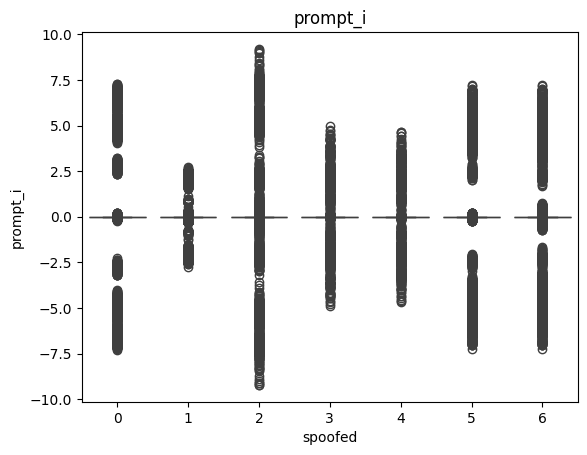

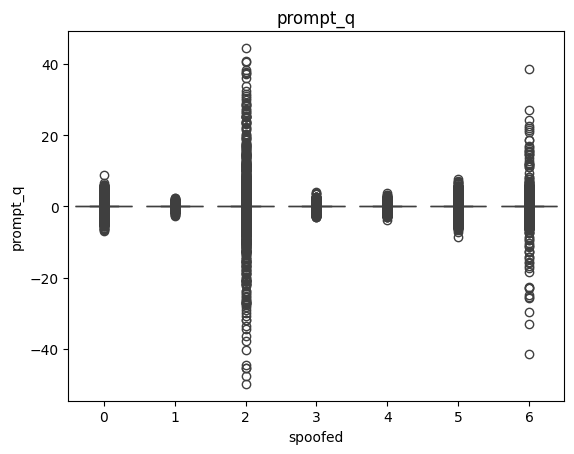

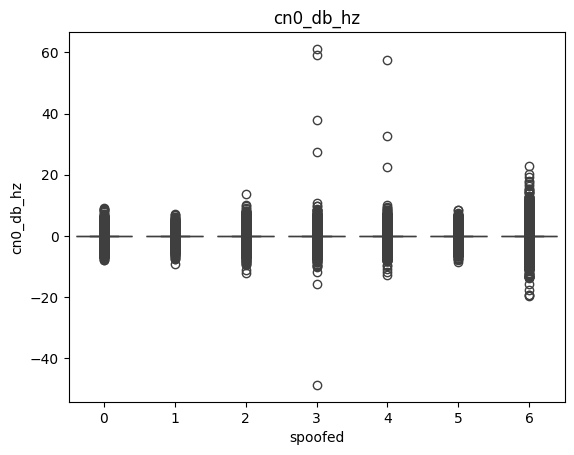

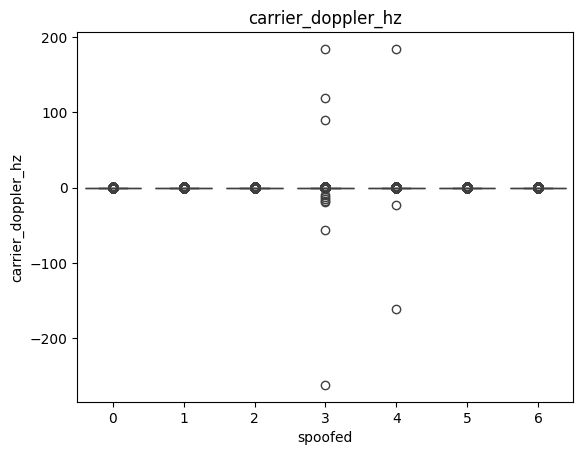

In [35]:
for col in X.columns:
    sns.boxplot(x=y, y=X[col])
    plt.title(col)
    plt.show()

In [36]:
svm = SVC(kernel='rbf', C=1.0, class_weight='balanced')
svm.fit(X_train, y_train)


SVC(class_weight='balanced')

In [37]:
svm_no_diff = SVC(kernel='rbf', C=1.0, class_weight='balanced')
svm_no_diff.fit(X_train_no_diff, y_train_no_diff)


SVC(class_weight='balanced')

In [38]:
y_pred = svm.predict(X_test)


In [39]:
y_pred_no_diff = svm_no_diff.predict(X_test_no_diff)

              precision    recall  f1-score   support

           0       0.35      0.05      0.08      5168
           1       0.16      0.98      0.27      5521
           2       0.48      0.02      0.04      5466
           3       0.33      0.04      0.07      5245
           4       0.27      0.04      0.07      5415
           5       0.33      0.04      0.08      5509
           6       0.41      0.03      0.06      5531

    accuracy                           0.17     37855
   macro avg       0.33      0.17      0.10     37855
weighted avg       0.33      0.17      0.10     37855



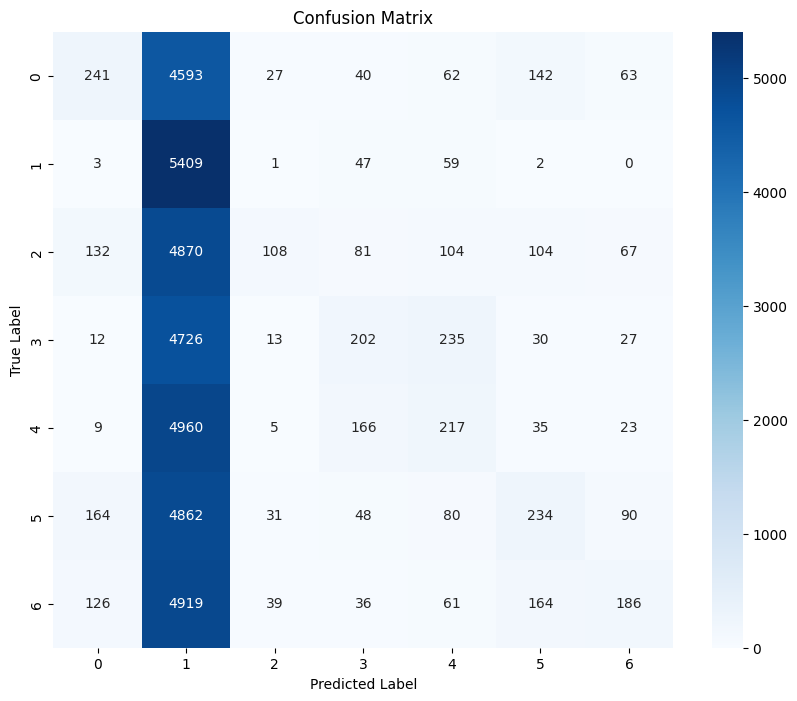

In [40]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.30      0.04      0.08      5222
           1       0.16      0.98      0.27      5583
           2       0.54      0.02      0.04      5360
           3       0.34      0.04      0.08      5165
           4       0.26      0.04      0.07      5400
           5       0.31      0.04      0.07      5613
           6       0.39      0.03      0.06      5512

    accuracy                           0.18     37855
   macro avg       0.33      0.17      0.09     37855
weighted avg       0.33      0.18      0.10     37855



Text(95.72222222222221, 0.5, 'True Label')

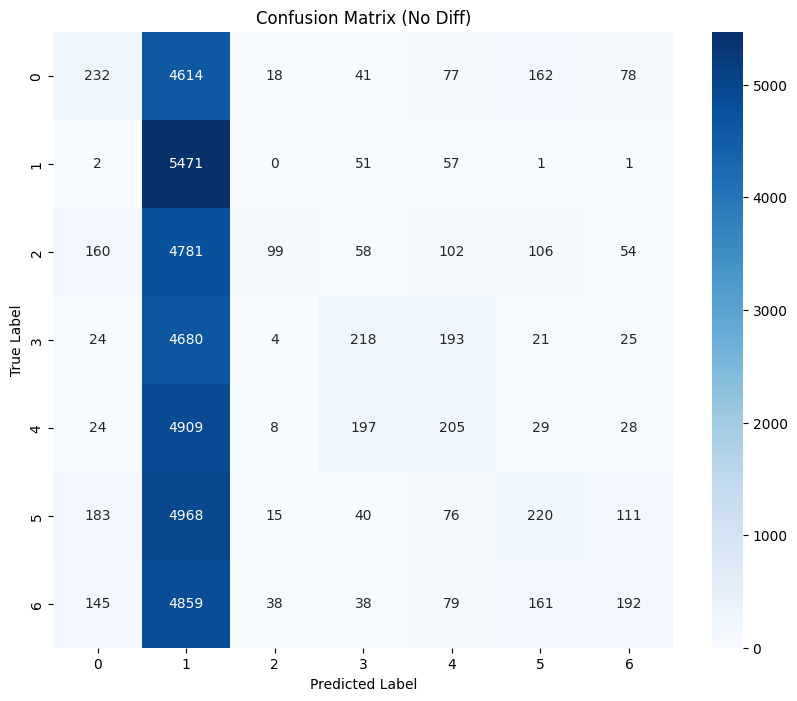

In [41]:
print(classification_report(y_test_no_diff, y_pred_no_diff))
cm_no_diff = confusion_matrix(y_test_no_diff, y_pred_no_diff)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [42]:
#random forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
rf_model.fit(X_train, y_train)

rf_model_no_diff = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
rf_model_no_diff.fit(X_train_no_diff, y_train_no_diff)

print("Random Forest")

importances = rf_model.feature_importances_
features = X_train.columns  # assuming 'spoofed' is last
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")

print("\nRandom Forest No Diff")

importances = rf_model_no_diff.feature_importances_
features = X_train.columns  # assuming 'spoofed' is last
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")

Random Forest
prompt_i: 0.3285
prompt_q: 0.2738
cn0_db_hz: 0.2013
carrier_doppler_hz: 0.1964

Random Forest No Diff
prompt_i: 0.3267
prompt_q: 0.2749
cn0_db_hz: 0.2026
carrier_doppler_hz: 0.1958


In [43]:
y_pred = rf_model.predict(X_test)
y_pred_no_diff = rf_model_no_diff.predict(X_test_no_diff)

              precision    recall  f1-score   support

           0       0.35      0.05      0.08      5168
           1       0.82      0.09      0.16      5521
           2       0.40      0.03      0.06      5466
           3       0.14      0.92      0.25      5245
           4       0.35      0.06      0.10      5415
           5       0.28      0.04      0.06      5509
           6       0.39      0.04      0.08      5531

    accuracy                           0.17     37855
   macro avg       0.39      0.17      0.11     37855
weighted avg       0.39      0.17      0.11     37855



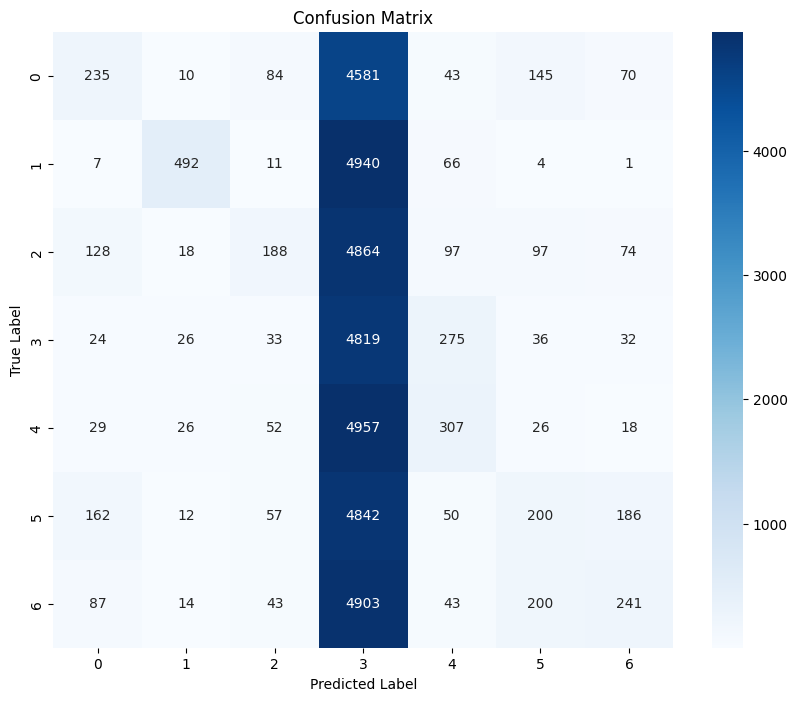

In [44]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.35      0.05      0.08      5168
           1       0.82      0.09      0.16      5521
           2       0.40      0.03      0.06      5466
           3       0.14      0.92      0.25      5245
           4       0.35      0.06      0.10      5415
           5       0.28      0.04      0.06      5509
           6       0.39      0.04      0.08      5531

    accuracy                           0.17     37855
   macro avg       0.39      0.17      0.11     37855
weighted avg       0.39      0.17      0.11     37855



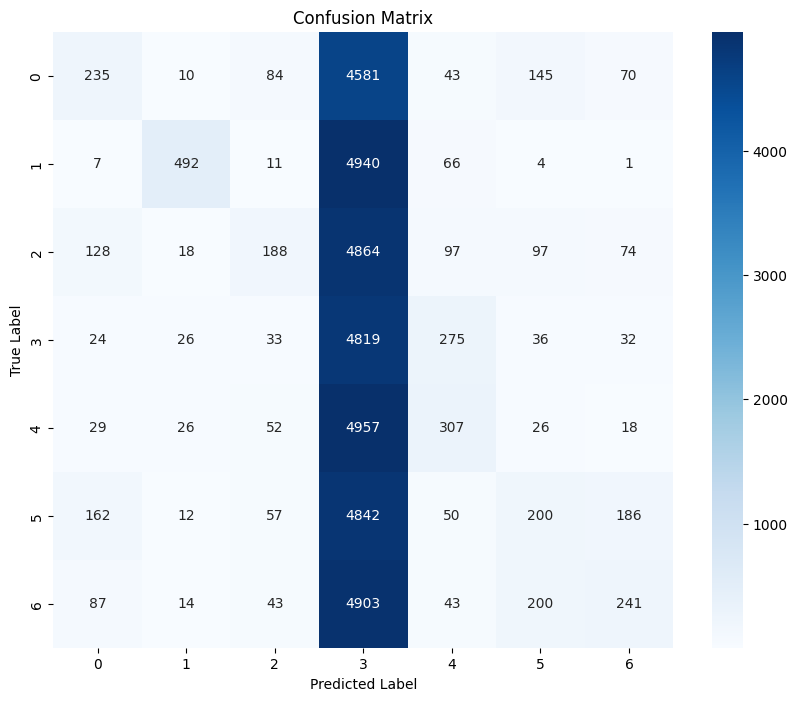

In [45]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

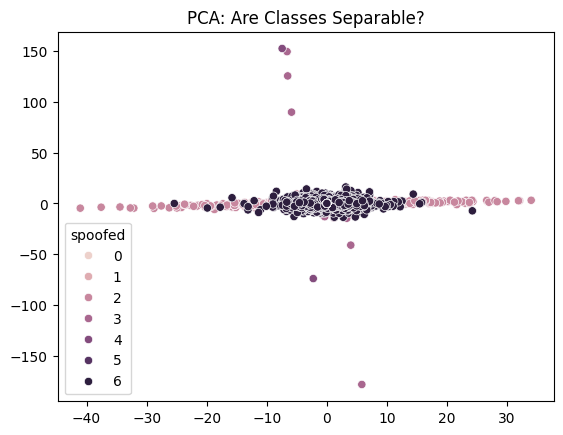

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y)
plt.title("PCA: Are Classes Separable?")
plt.show()
